In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats
import statsmodels.api as sm
from datetime import date
from sklearn import metrics

# Preprocessing

In [13]:
ames = pd.read_csv('../frames/training.csv')
ames_test = pd.read_csv('../frames/testing.csv')
ames_raw = pd.read_csv('../data/train.csv') # easier with categorical values

In [14]:
# Splitting and scaling our training and testing data
X = ames.drop(columns=['SalePrice']) # grabbing it all
y = ames['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=13, test_size=.2)

# scaler object
sc = StandardScaler()

# Testing

## Baseline 'Kitchen Sink' Model

In [15]:
# creating the model
Z_train = sc.fit_transform(X_train) # fitting our training data with scaler
Z_test = sc.transform(X_test)

model = LinearRegression()
model.fit(Z_train, y_train)

#displaying results
print(cross_val_score(model, Z_train, y_train).mean())
print(model.score(Z_test,y_test))

-3.672226611467727e+22
-4.142099907099989e+21


#### It's terrible! 
But thats not a bad thing, we want a baseline model to tell us if our theories are going to be worth anything. If our models perform worse than the baseline, we know we are on the wrong track. We are going to aim for two models in this: an explanable one, and the best one we could get.

## Linear Model

In [16]:
# pearson scores of the most effective variables  
ames.corr()['SalePrice'].sort_values(ascending=False).head() # use tail for least

SalePrice       1.000000
Overall Qual    0.800207
Exter Qual      0.712146
curb_appeal     0.707847
total_SF        0.705270
Name: SalePrice, dtype: float64

In [17]:
features = [
    'Overall Qual', 'Kitchen Qual', 'Exter Qual', 'curb_appeal', 
    'Garage Cars', 'Fireplaces', 'TotRms AbvGrd', 'Mas Vnr Area', 
    'Neighborhood_NridgHt', 'Bsmt Exposure_Gd', 'Lot Frontage', 'house_age',
]

X = ames[features] 
y = ames['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=13,test_size=.2)

# scaling variables
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

# creating the model
model = LinearRegression()
model.fit(Z_train, y_train)

#displaying results
print(cross_val_score(model, Z_train, y_train).mean())
print(model.score(Z_test,y_test))
print(f'Root Mean Squared Error on testing data: {metrics.mean_squared_error(y_test,model.predict(Z_test),squared=False)}')

0.8049555871351519
0.7933642211519085
Root Mean Squared Error on testing data: 35772.7384885516


In [18]:
x = sm.add_constant(Z_train)
ols = sm.OLS(y_train,x).fit()

In [8]:
params = dict(zip(X.keys(),ols.params.values[1:]))
print('Constant: ', ols.params.values[0])
pd.Series(params).sort_values(ascending=False)

Constant:  181150.33414634143


Overall Qual            19582.038532
TotRms AbvGrd           13712.161151
Kitchen Qual            11818.565262
Bsmt Exposure_Gd         9858.195116
Exter Qual               9776.625842
Garage Cars              8919.068670
Fireplaces               8766.458349
Mas Vnr Area             6904.899259
curb_appeal              5748.861061
Neighborhood_NridgHt     5681.345929
Lot Frontage             3878.388312
house_age               -3770.734730
dtype: float64

Above is a the different predictors and their coefficients. We can see that Overall Qual is the most significant adding roughly \$21k
of value to the house. `**house_age**` is an engineered variable created by subtracting the year sold from the year built. One of the big issues, again, is that there aren't many variables that reall significantally took away from price, only variables that added to it. When I did other iterations, I decided to not add the other values because they either did not affect the scores meaningfully, or their p-values were very high, or both.

/Users/evanhoefling/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


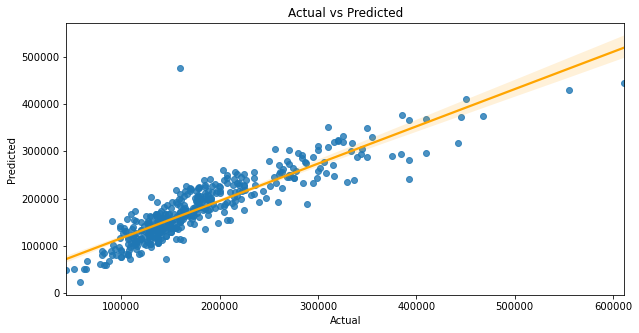

In [19]:
# prediction visual
y_preds = model.predict(Z_test)
plt.figure(figsize=(10,5))
sns.regplot(y_test, y_preds, line_kws={'color':'orange'})
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted');

Our model tells us that we are accounting for 79% of the movement in SalePrice with the independent variables we have chosen. The breakdown goes as follows: 

Out of all the variables Overall Quality seemed to have the biggest impact, which was not a surprise given how strongly it is correlated to the `SalePrice` variable in our training set. The biggest issue with this model is that we don't have any variables that are lowering the house price. In fact, when a variable with a negative correlation to `SalePrice` is given, the model becomes less accurate. If I were to do this again, I think I would have to go back and really try to engineer such features.

## Ridge Model

In [21]:
# pluggin into ridge
features = [
    'Overall Qual', 'Total Bsmt SF', 'Exter Qual',
    'Kitchen Qual', '1st Flr SF', 'Exter Qual', 
    'curb_appeal', 'Garage Yr Blt', 'overalls',
    'Garage Area', 'TotRms AbvGrd', 'Lot Frontage',
    'Bsmt Full Bath', 'Overall Qual','Fireplaces', 
    'Year Remod/Add', 'PID', 'Roof Style_Gable',
    'Neighborhood_Edwards', 'MS Zoning_RM', 'Bsmt Exposure_No', 
    'Full Bath','Fireplace Qu', 'Year Built', 
    'total_SF', 'Gr Liv Area', 
]

X = ames[features]
y = ames['SalePrice']

poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
X_overfit = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_overfit,y,
                                                   random_state=13,
                                                   test_size=.2)
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

# Evaluate model using ridge.
ridge_model = Ridge(alpha=100)
# Fit.
ridge_model.fit(Z_train, y_train)
print(cross_val_score(ridge_model, Z_train, y_train, n_jobs=-1).mean())
print(ridge_model.score(Z_test, y_test))
print(f'Root Mean Squared Error on training data: {metrics.mean_squared_error(y_train,ridge_model.predict(Z_train),squared=False)}')
print(f'Root Mean Squared Error on testing data: {metrics.mean_squared_error(y_test,ridge_model.predict(Z_test),squared=False)}')

0.8932591634871082
0.9019995081673895
Root Mean Squared Error on training data: 17891.601969139796
Root Mean Squared Error on testing data: 24635.623292228625


/Users/evanhoefling/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


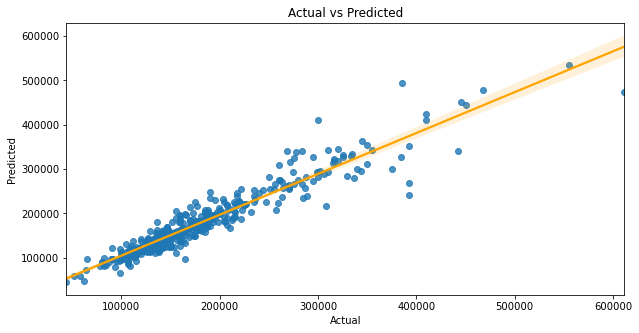

In [22]:
y_preds = ridge_model.predict(Z_test)
plt.figure(figsize=(10,5))
sns.regplot(y_test, y_preds, line_kws={'color':'orange'})
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted');

So I ended up not going over the ridge model in my presentation, but I did use it to make my prediction submissions. The first couple of predictions I made got really close, but then I realized I wasn't cross validating the scores, so I re-did my model. I was able to get it to about 90% accuracy on the testing data with realtively small rmse as well.

In [32]:
# creating a submission csv
X = ames_test[features]
X_overfit = poly.fit_transform(X)
Z_test = sc.fit_transform(X_overfit)
ames_test['SalePrice'] = ridge_model.predict(Z_test)
sub = ames_test[['Id','SalePrice']]
sub.to_csv('../subs/ridged22.csv',index=False)